In [224]:
# SYSTEM
from os import sys, cpu_count
from time import time
from multiprocessing import Process
from multiprocessing.shared_memory import SharedMemory

# DATA TOOLS
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import  LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# PACKAGE CONFIG
mpl.rcParams.update({'font.size':16})

In [2]:
# MULTIPROCESSING DEFINTIONS

"""
MP TEST FUNCTION
def is_even(ARRAY,OUTPUT):
    for i in range(len(ARRAY)):   
        if (np.round(ARRAY[i]) % 2) == 0.0:
            OUTPUT[i] = 1
        else:
            OUTPUT[i] = 0
"""

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[0]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[0] - distance
    return work_schedule

"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT_ARRAY, TASK, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        print(f'start {i}')
        position = WORK_SCHEDULE[i,0]
        magnitude = WORK_SCHEDULE[i,1]
        jobslice = INPUT_ARRAY[position:int(position+magnitude)]
        jobslice_str = str(jobslice)
        outslice = OUTPUT[position:int(position+magnitude)]
        p = Process(target=TASK, args=(jobslice,outslice))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        print(f'join {i}')
        processes[i].join()

In [3]:
df = pd.read_csv('./input/train.csv')

In [4]:
# An array of the cumulative inflation rates for the years 2006-2010 until 2021
# IE between 2006 and 2021 there is a cumlative rate of inflation equal to 29.8%
inflation2021 = np.array([[2006,0.29752976],
                          [2007,0.26159678],
                          [2008,0.21494824],
                          [2009,0.21928618],
                          [2010,0.19960927]])

# Function which, given YrSold, converts associated value of SalePrice
# by accounting for inflation. A Box-Cox transform is then performed on
# the adjusted value to make the distribution more normal looking.
def adj4inf(YEAR, DOLLARS):
    for i in range(len(inflation2021)):
        if YEAR == inflation2021[i,0]:
            adjvalue = DOLLARS*(1+inflation2021[i,1])
            break
    return np.log(adjvalue) # Note the logarithm feat. Box-Cox(1964)
df.shape

(1460, 81)

In [5]:
if 'adjprice' in df:
    None
else:
    adjprices = []
    for i in range(len(df)):
        adjprices.append(adj4inf(df['YrSold'][i],df['SalePrice'][i]))
    df.insert(loc=81,column='adjprice',value=adjprices)
    del adjprices
df.iloc[0:5,70:]

,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,adjprice
0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.442396
1,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.341389
2,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.511868
3,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,12.109860
4,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.623918


p = 2.81836e-06
The null hypothesis can be rejected


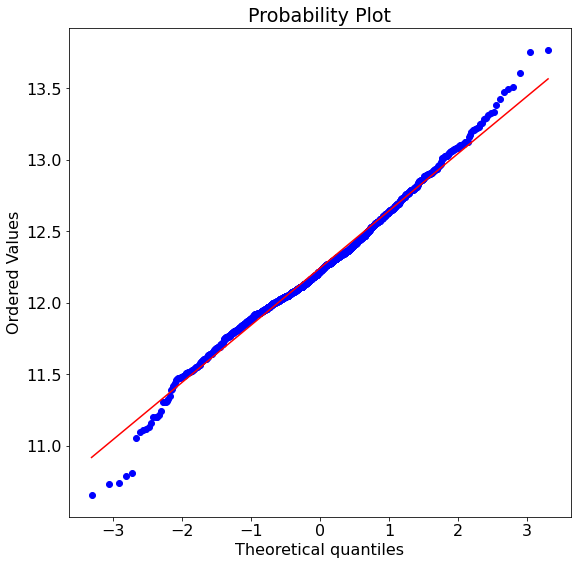

In [6]:
#target, lamda = stats.boxcox(np.array(df['adjprice']))
#target = np.array(df[df[VAR] == '2Story']['SalePrice'])
target = np.array(df['adjprice'])

k2, p = stats.normaltest(target)
alpha = 50e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
fig, ax = plt.subplots(figsize= (9,9))
stats.probplot(target,plot=ax)
plt.show()

# Missing Values 

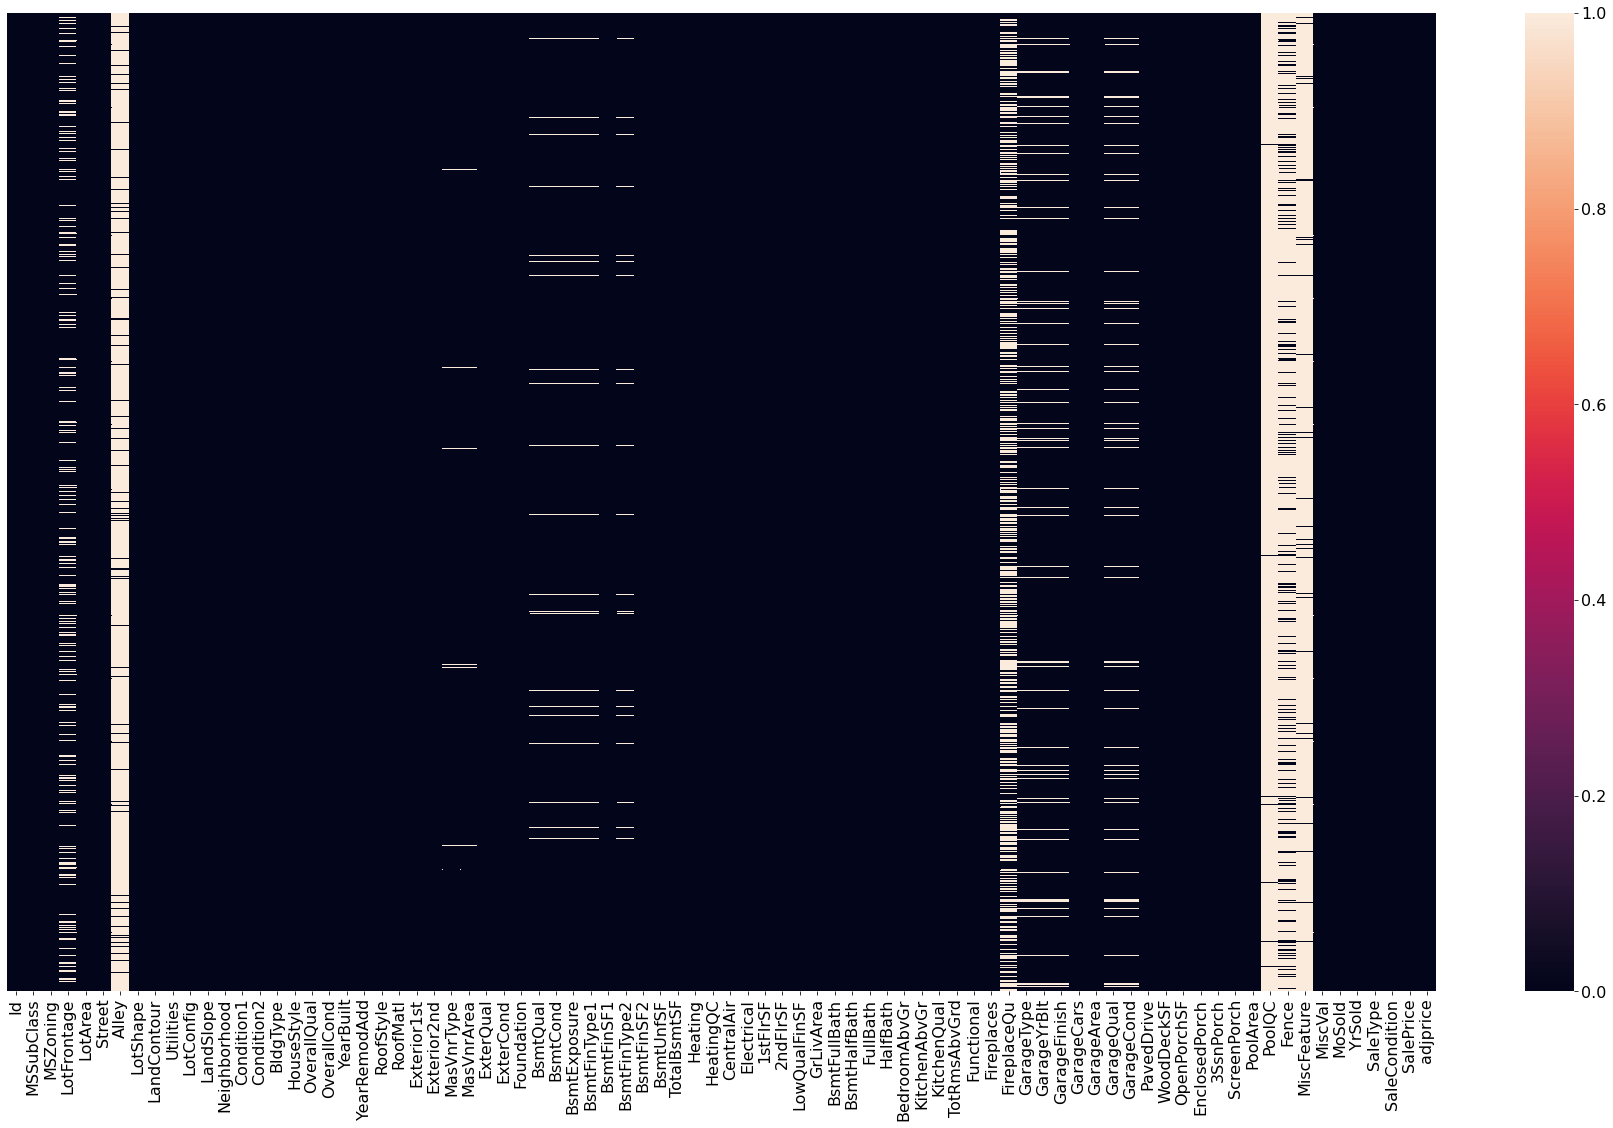

In [7]:
plt.figure(figsize=(32,18))
sns.heatmap(df.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

In [8]:
df.columns[df.isnull().any() == True]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## LotFrontage

A NaN for LotFrontage could indicate may indicate there is no street access to the parcel. Since zero of the parcels which have an NaN for LotFrontage have a NaN for Street type, I will replace the NaN in LotFrontage with the product of the mean frontage ratio for all data and the LotArea where the LotFrontage is missing.

In [9]:
mean_frontage_ratio = np.mean(df['LotFrontage']/df['LotArea'])
df['LotFrontage'].replace(np.nan,mean_frontage_ratio*df['LotArea'],inplace=True)

In [10]:
df.columns[df.isnull().any() == True]

Index(['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## Alley

In [11]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [12]:
df['Alley'].replace(np.nan,'None',inplace=True)

##  MasVnrType, MasVnrArea

In [13]:
df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [14]:
df['MasVnrArea'].replace(np.nan,0,inplace=True)
df['MasVnrType'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [15]:
df['BsmtQual'].replace(np.nan,'None',inplace=True)
df['BsmtCond'].replace(np.nan,'None',inplace=True)
df['BsmtExposure'].replace(np.nan,'None',inplace=True)
df['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df['BsmtFinType2'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

## Electrical

In [16]:
df[df['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,adjprice
1379,1380,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,167500,12.22344


In [17]:
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [18]:
df['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df.columns[df.isnull().any() == True]

Index(['FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## FireplaceQu

In [19]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [20]:
len(df[df['FireplaceQu'].isnull() & df['Fireplaces'] != 0])

0

In [21]:
df['FireplaceQu'].replace(np.nan,'None',inplace=True)
df.columns[df.isnull().any() == True]

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

## GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

In [22]:
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageYrBlt'].replace(np.nan,df['GarageYrBlt'].mean(),inplace=True)
df['GarageFinish'].replace(np.nan,'None',inplace=True)
df['GarageQual'].replace(np.nan,'None',inplace=True)
df['GarageCond'].replace(np.nan,'None',inplace=True)

df.columns[df.isnull().any() == True]

Index(['PoolQC', 'Fence', 'MiscFeature'], dtype='object')

## PoolQC

In [23]:
len(df[df['PoolQC'].isnull() & df['PoolArea'] != 0])

0

In [24]:
df['PoolQC'].replace(np.nan,'None',inplace=True)

## Fence

In [25]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [26]:
df['Fence'].replace(np.nan,'None',inplace=True)

## MiscFeature

In [27]:
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [28]:
df['MiscFeature'].replace(np.nan,'None',inplace=True)

In [29]:
#!rm datatypes.npy

In [30]:
# datatype array contains what type of data is contained in each column of df
#
# KEY
# ==========
# 0 - nominal
# 1 - ordinal
# 2 - interval
# 3 - ratio

try:
    with open('./datatypes.npy','rb') as f:
        datatype = np.load(f)
except:
    datatype = np.zeros(len(df.columns))
    for i in range(len(df.columns)):
        datatype[i] = input(f'{df.columns[i]}')
        np.save('./datatypes.npy',datatype)
datatype[0:5]

array([3., 0., 0., 3., 3.])

In [31]:
categoric = []
numeric = []
for i in range(len(datatype)):
    if datatype[i] <= 1:
        categoric.append(df.columns[i])
    else:
        numeric.append(df.columns[i])

In [32]:
plt.figure(figsize=(128,64))
df_model.corr()['adjprice'].sort_values(ascending=False).plot(kind='bar')
plt.axhline(0.5,color = 'red')
plt.show()

NameError: name 'df_model' is not defined

<Figure size 9216x4608 with 0 Axes>

In [ ]:
df['MSZoning'].value_counts()

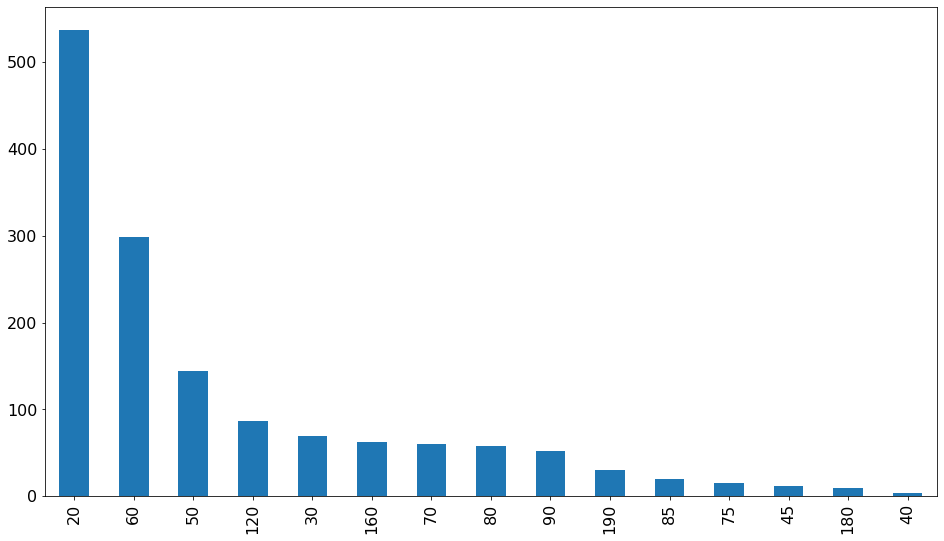

In [33]:
plt.figure(figsize=(16,9))
df['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

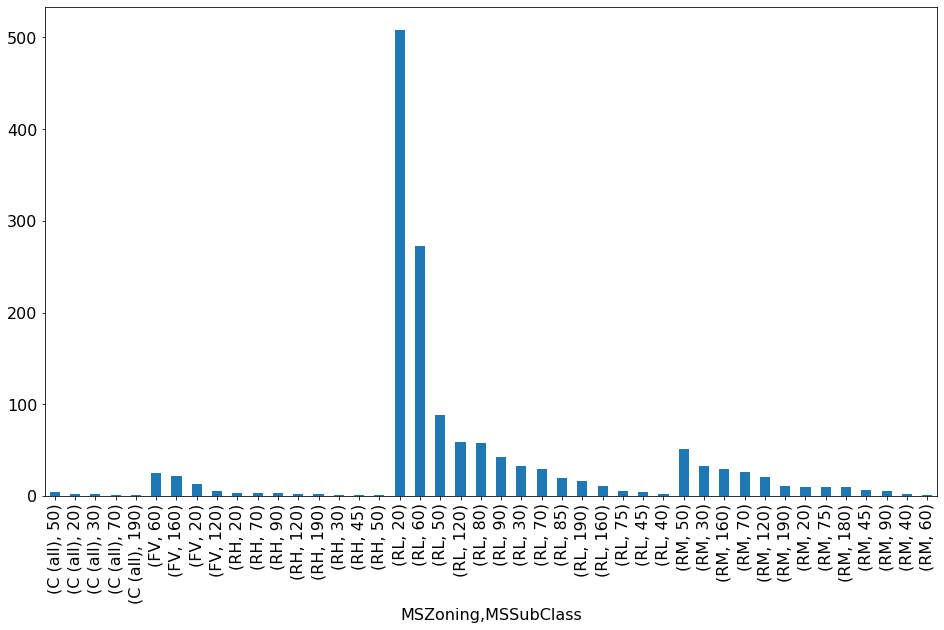

In [34]:
plt.figure(figsize=(16,9))
df.groupby('MSZoning')['MSSubClass'].value_counts().plot(kind='bar')
plt.show()

In [35]:
def get_vecs(FEATURE, DATAFRAME, TARGET):
    vector = []
    variables = np.array(DATAFRAME.loc[:,FEATURE].value_counts().index,dtype=object)
    for i in range(len(variables)):
        vector.append(DATAFRAME[DATAFRAME.loc[:,FEATURE] == variables[i]][TARGET])
    return np.asarray(vector, dtype=object), variables

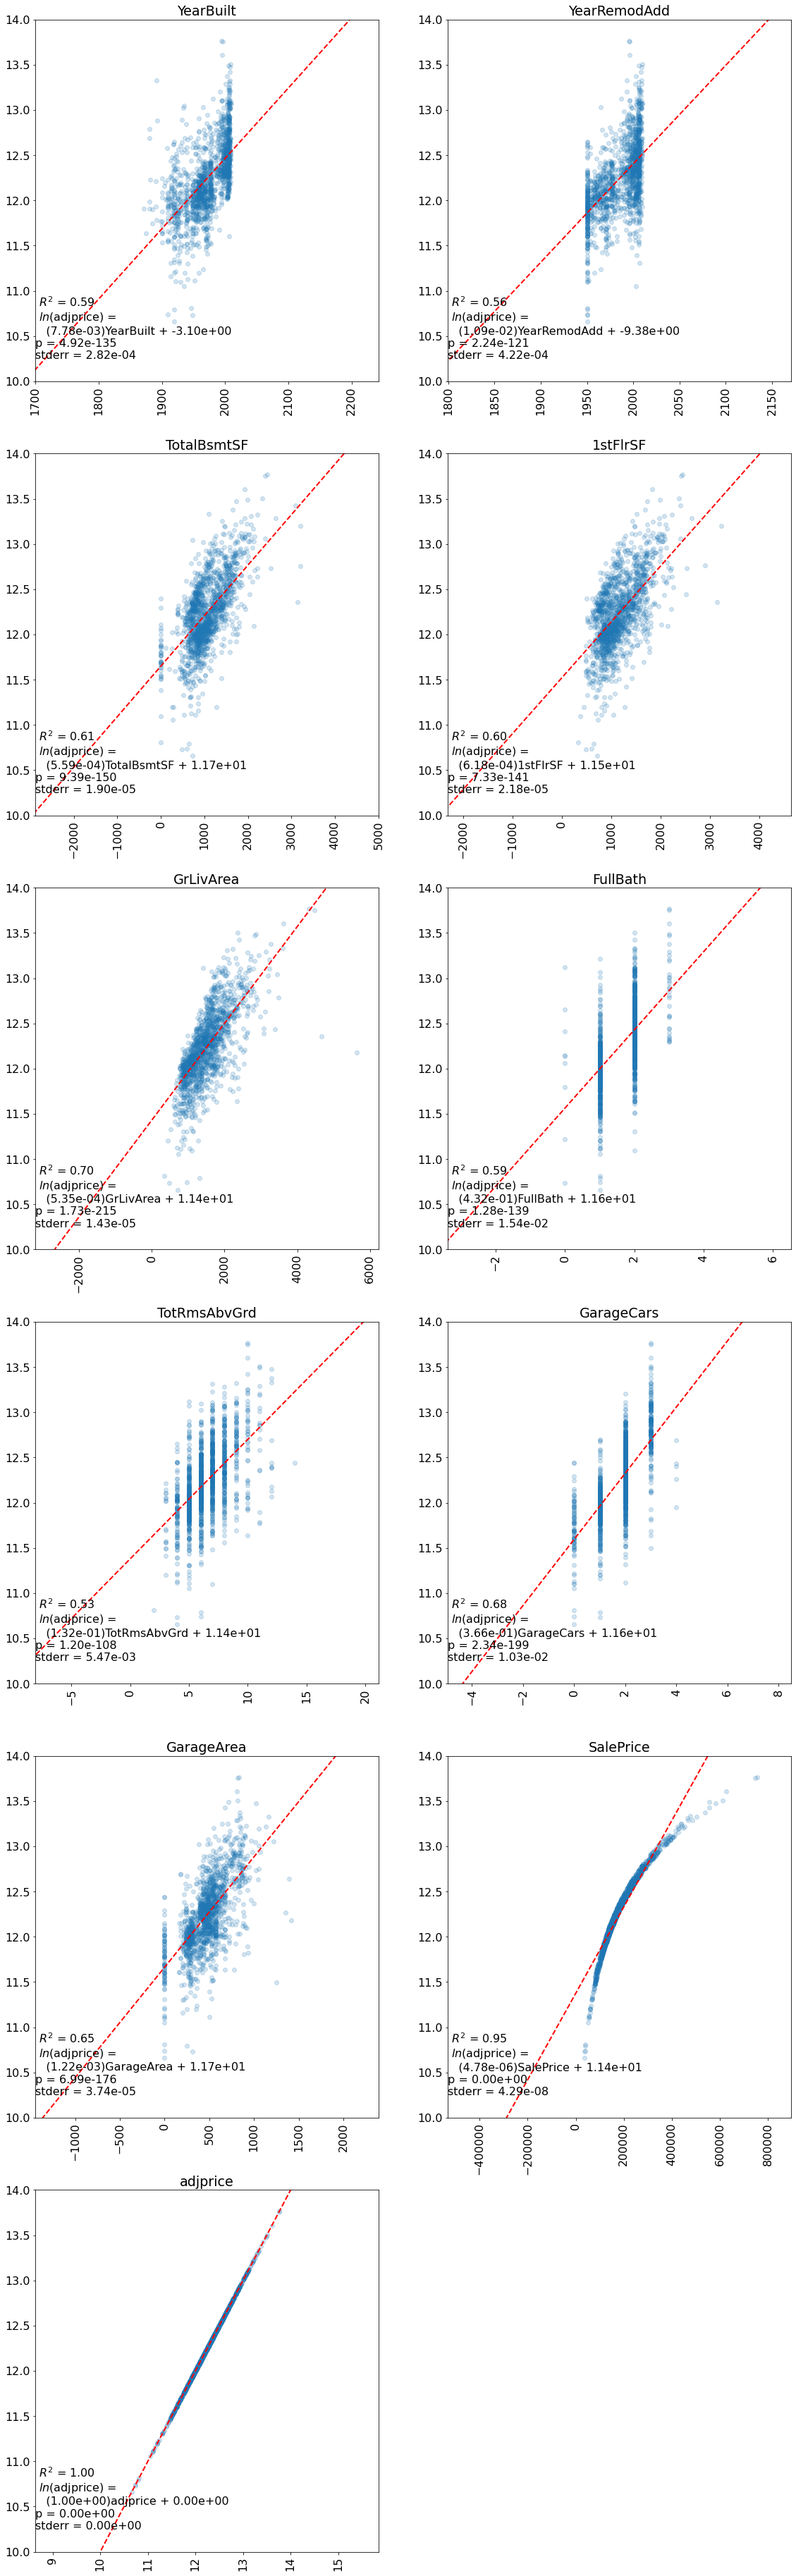

In [36]:
def bestfit(NUMERIC, TARGET):
    slope, intercept, r, p, std_err = stats.linregress(NUMERIC, TARGET)
    return slope, intercept

fig, axs = plt.subplots(figsize=(16,256))
fig.tight_layout()
j = 0
for i in range(1,len(numeric)):
    
    slope, intercept, r, p, std_err = stats.linregress(df[numeric[i]],df['adjprice'])
    if r >= 0.5:
        j = j+1
        devs = 9
        xmin = np.mean(df[numeric[i]]) - devs*np.std(df[numeric[i]])
        xmax = np.mean(df[numeric[i]]) + devs*np.std(df[numeric[i]])
        domain = np.linspace(-1e9,1e9,10)
        y_pred = slope*domain + intercept
        plt.subplot(30,2,j)
        plt.xlim(xmin,xmax)
        plt.ylim(10,14)
        plt.scatter(df[numeric[i]],df['adjprice'],alpha=0.2)
        plt.plot(domain,y_pred,c = 'r', linestyle='--',linewidth=2)
        plt.xticks(rotation=90)
        plt.text(xmin,10.25,
        f' $R^2$ = {r:.2f}\
        \n $ln$(adjprice) =\
        \n   ({slope:.2e}){numeric[i]} + {intercept:.2e}\
        \np = {p:.2e}\nstderr = {std_err:.2e}')
        plt.title(numeric[i])
    else:
        continue

plt.show()

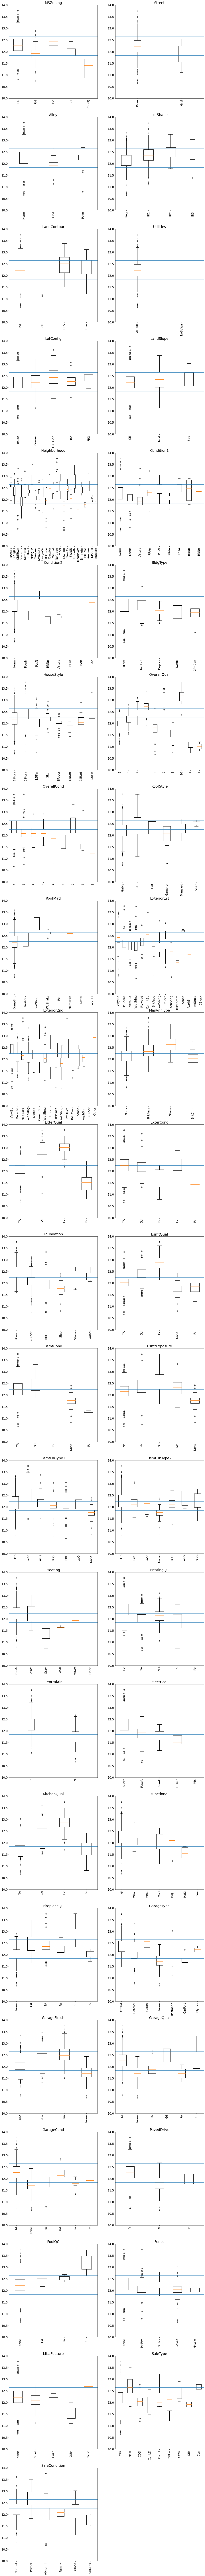

In [37]:
fig, ax = plt.subplots(figsize=(16,256))
fig.tight_layout()
for i in range(1,len(categoric)):
    vecs = get_vecs(categoric[i],df,'adjprice')
    plt.subplot(30,2,i)
    plt.ylim(10,14)
    plt.boxplot(vecs[0],labels=vecs[1])
    plt.xticks(rotation=90)
    plt.title(categoric[i])
    plt.axhline(df['adjprice'].mean(), c = 'C0')
    plt.axhline(df['adjprice'].mean() + np.std(df['adjprice']), c = 'C0')
    plt.axhline(df['adjprice'].mean() - np.std(df['adjprice']), c = 'C0')
plt.show()

In [38]:
def get_ranks(FEATURE, DATAFRAME, TARGET):
    ftr_mean = np.zeros(len(DATAFRAME[FEATURE].unique()))
    vecs = get_vecs(FEATURE, DATAFRAME, TARGET)
    for i in range(len(ftr_mean)):
        ftr_mean[i] = np.mean(vecs[0][i])
    ftr_rank = np.zeros(len(DATAFRAME),dtype=np.uint8)
    target_mean = np.mean(DATAFRAME[TARGET])
    target_std = np.std(DATAFRAME[TARGET])
    for i in range(len(df)):
        for j in range(len(vecs[1])):
            if DATAFRAME[FEATURE][i] == vecs[1][j]:
                if  ftr_mean[j] <= (target_mean - target_std):
                    ftr_rank[i] = 1
                if (ftr_mean[j] > (target_mean - target_std)) & (ftr_mean[j] <= target_mean):
                    ftr_rank[i] = 2
                if (ftr_mean[j] <= (target_mean + target_std)) & (ftr_mean[j] > target_mean):
                    ftr_rank[i] = 3
                if (ftr_mean[j] > (target_mean + target_std)):
                    ftr_rank[i] = 4
    return ftr_rank

In [39]:
#for i in range(len(df_model.columns)):
#    print("'"+df_model.columns[i]+"',")

#  Basic Model

In [419]:
# Begin by including all features in our model
df_model = pd.DataFrame()
for i in range(len(categoric)):
    try:
        tmp_str = categoric[i] + '_ranks'
        df_model.loc[:,tmp_str] = get_ranks(categoric[i],df,'adjprice')
    except:
        continue
df_cats = df.loc[:,numeric]
df_model = df_cats.merge(df_model, how='inner', left_index=True,right_index=True)
df_model = df_model.drop('SalePrice',axis=1)
df_model = df_model.drop('adjprice',axis=1)
df_model[0:5]

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType_ranks,GarageFinish_ranks,GarageQual_ranks,GarageCond_ranks,PavedDrive_ranks,PoolQC_ranks,Fence_ranks,MiscFeature_ranks,SaleType_ranks,SaleCondition_ranks
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,...,3,3,3,3,3,2,3,3,2,2
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,...,3,3,3,3,3,2,3,3,2,2
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,...,3,3,3,3,3,2,3,3,2,2
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,...,2,2,3,3,3,2,3,3,2,2
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,...,3,3,3,3,3,2,3,3,2,2


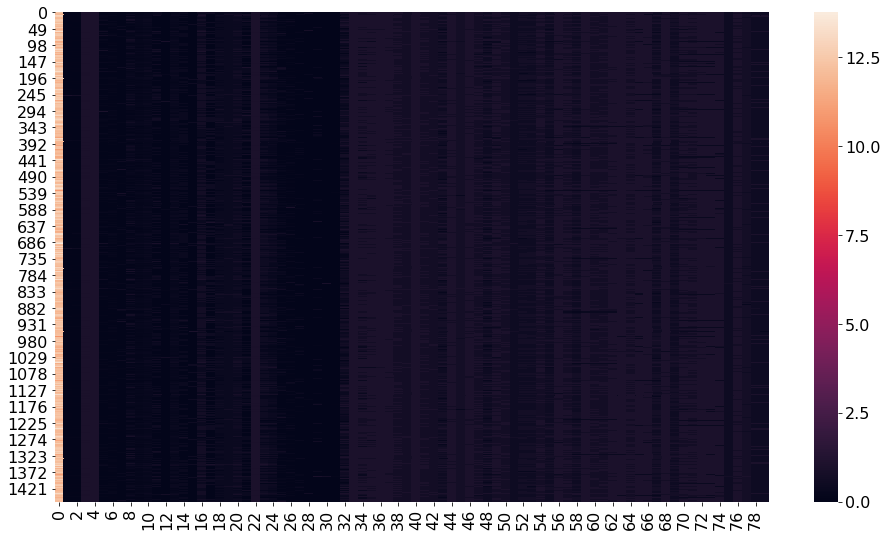

In [423]:
X = np.array(df_model,dtype = np.float64)
y = np.array(df.adjprice, dtype=np.float64)#df_model.iloc[:,0]

yX = np.array(df_model,dtype=np.float64)
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df['adjprice']


plt.figure(figsize=(16,9))
sns.heatmap(yX[:,:])

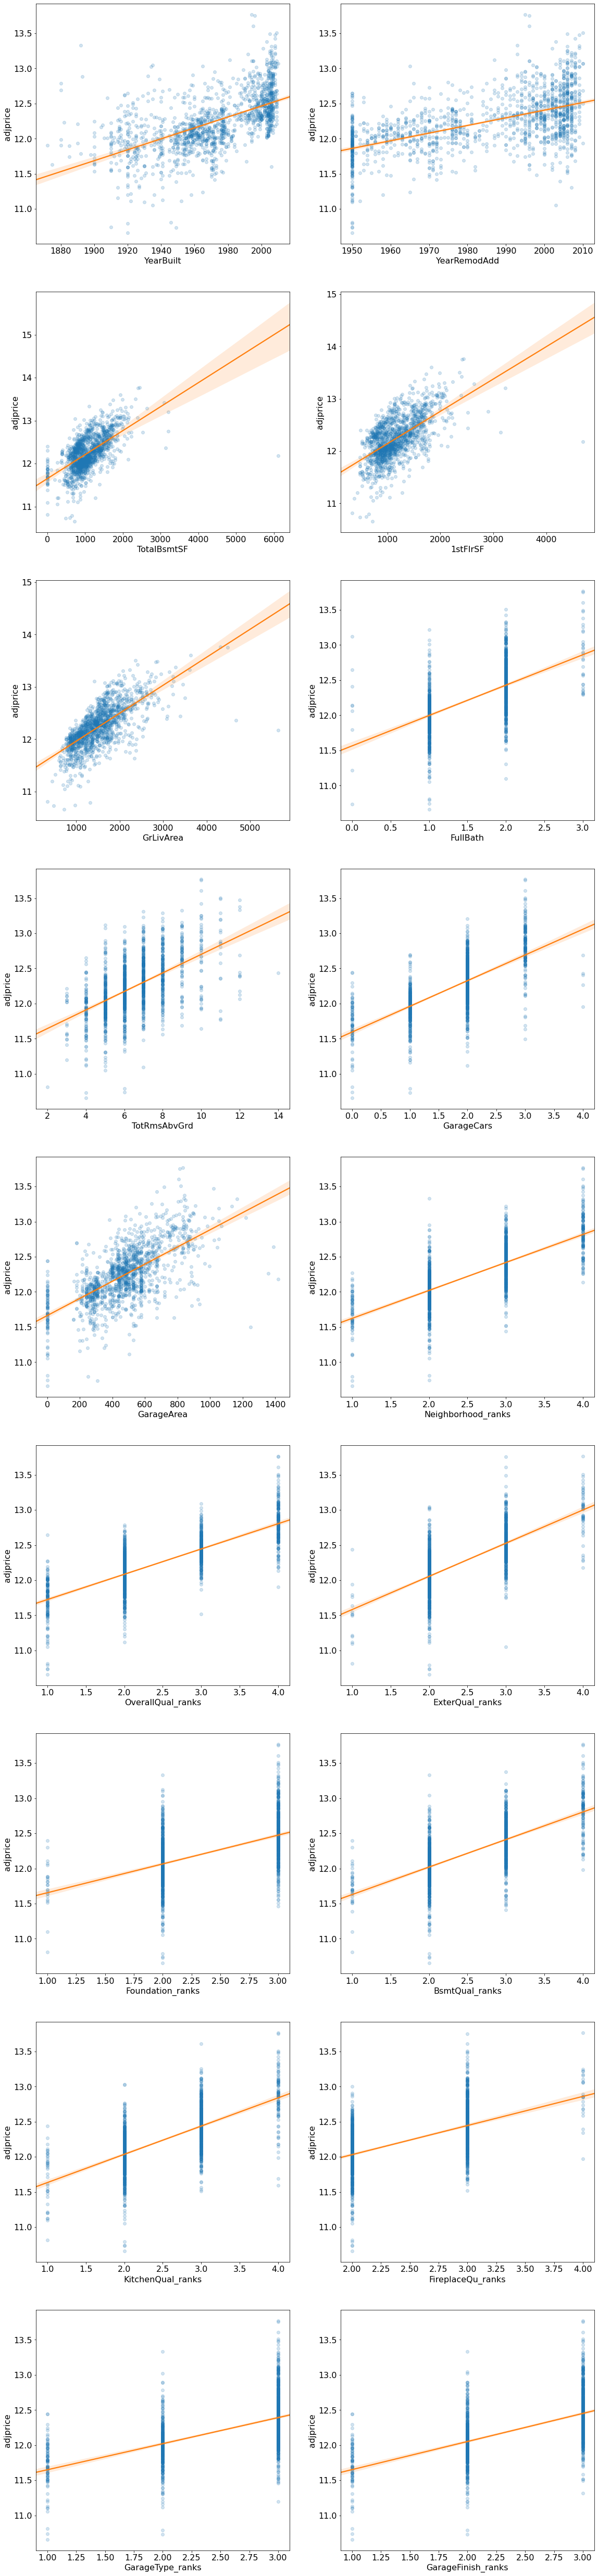

In [52]:
fig, ax = plt.subplots(figsize=(16,384))
fig.tight_layout()
j = 0
newcats = []
for i in range(0,len(df_model.columns)):
        if stats.pearsonr(df_model[df_model.columns[i]],df.adjprice)[0] >= 0.5:
            j = j+1
            plt.subplot(50,2,j)
            sns.regplot(df_model[df_model.columns[i]], # X
                    df.adjprice, # y
                    scatter_kws={'alpha':0.2},
                    line_kws={'color':'C1'})
            newcats.append(df_model.columns[i])
        else:
            continue
plt.show()

In [73]:
df_price = df.adjprice
df_model = pd.merge(df_price,df_model.loc[:,newcats],left_index=True,right_index=True)
print(df_model.shape)
df_model[0:5]

(1460, 19)


,adjprice,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,Neighborhood_ranks,OverallQual_ranks,ExterQual_ranks,Foundation_ranks,BsmtQual_ranks,KitchenQual_ranks,FireplaceQu_ranks,GarageType_ranks,GarageFinish_ranks
0,12.442396,2003,2003,856,856,1710,2,8,2,548,3,3,3,3,3,3,2,3,3
1,12.341389,1976,1976,1262,1262,1262,2,6,2,460,3,2,2,2,3,2,3,3,3
2,12.511868,2001,2002,920,920,1786,2,6,2,608,3,3,3,3,3,3,3,3,3
3,12.109860,1915,1970,756,961,1717,1,7,3,642,3,3,2,2,2,3,3,2,2
4,12.623918,2000,2000,1145,1145,2198,2,9,3,836,4,4,3,3,3,3,3,3,3


In [246]:
df_model.shape

(1460, 19)

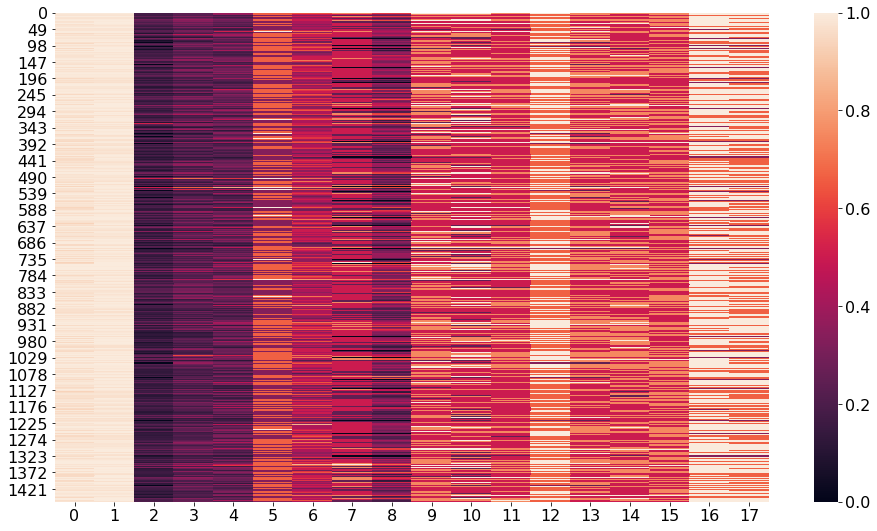

In [413]:
template = np.zeros((df_model.shape),dtype=np.float64)
yX_shm = SharedMemory(create=True, size=template.nbytes)
yX = np.ndarray(template.shape, dtype=template.dtype, buffer=yX_shm.buf)

yX[:] = np.array(df_model,dtype=np.float64)[:]
yX = normalize(yX, norm='max', axis=0)
yX[:,0] = df_model['adjprice']
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])

In [313]:
# MULTIPROCESSING DEFINTIONS

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[0]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[0] - distance
    return work_schedule


def perform_work(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    y = INPUT[:,0]
    for i in range(0, DURATION):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        reg = MODEL_TYPE
        reg.fit(X_train, y_train)
        OUTPUT[0][i + OFFSET] = reg.score(X_test,y_test)
        OUTPUT[1][i + OFFSET] = np.sqrt(np.mean((np.exp(reg.predict(X_test)) - np.exp(y_test))**2))

"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT, TASK, MODEL_TYPE, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        #print(f'start {i}')
        p = Process(target=TASK, args=(INPUT,OUTPUT, MODEL_TYPE, WORK_SCHEDULE[i,0], WORK_SCHEDULE[i,1]))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        #print(f'join {i}')
        processes[i].join()

In [397]:
def draw_plots(MODEL_TYPE, WORKOUTPUT, BINS):
    plt.subplots(2,1,figsize=(16,16))
    xlab = ['$R^2$','RMSE\n($USD, adjusted for inflation 2021)']
    for i in range(0,2):
        plt.subplot(2, 1, i + 1)
        plt.hist(WORKOUTPUT[i],bins=BINS)
        plt.title(f'{str(MODEL_TYPE)} (N={testlen:,})')
        plt.xlabel(xlab[i])
        plt.xlim()
        plt.ylabel('Frequency')
    plt.show()

    print('========')
    print(' Scores ')
    tmp = sp.stats.describe(WORKOUTPUT[0])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

    print('========')
    print(' Error  ')
    tmp = sp.stats.describe(WORKOUTPUT[1])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

Time Elapsed: 64.424s


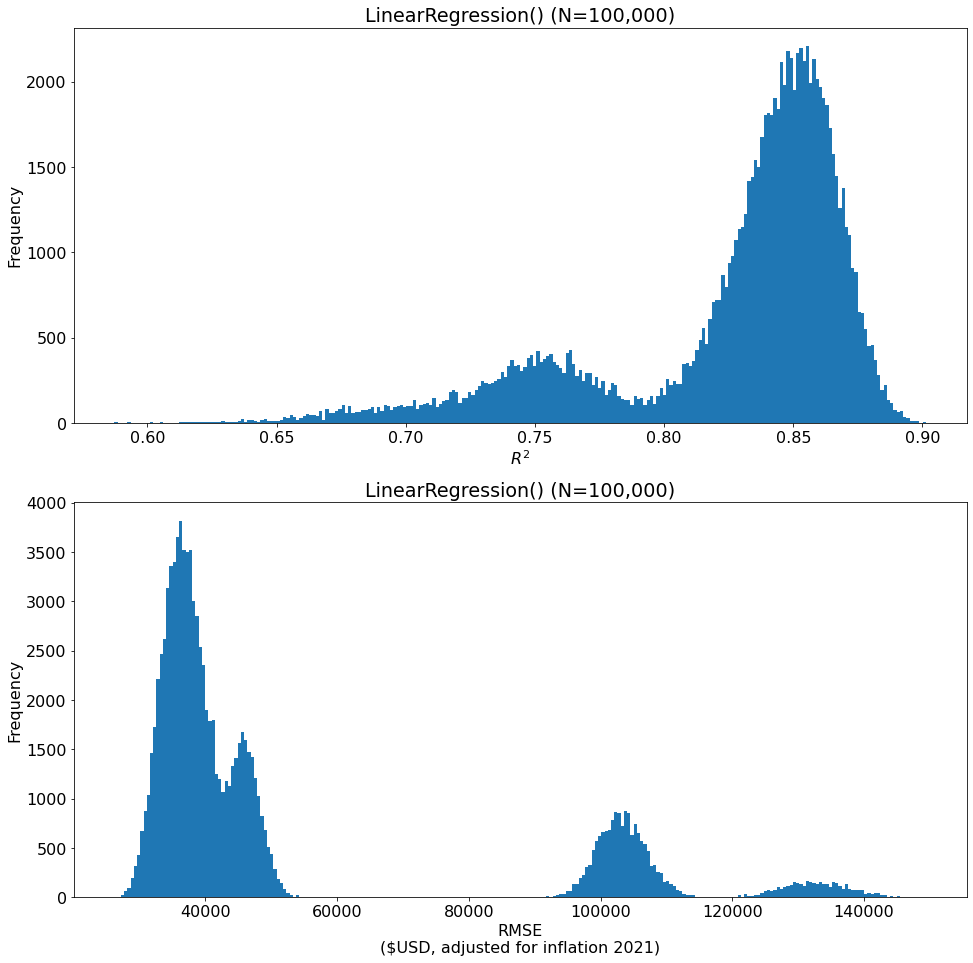

 Scores 
nobs:    	100000
minmax:  	(0.587184606350807, 0.901336756316448)
mean:    	0.8256995452344549
variance:	0.0023843009251747157
skewness:	-1.4767837992765773
kurtosis:	1.5876395253641702
 Error  
nobs:    	100000
minmax:  	(26168.73412610826, 149382.61586938213)
mean:    	52718.934431389236
variance:	843239769.5719079
skewness:	1.5784333540020146
kurtosis:	0.9563160184800816


In [398]:
start_time = time()

testlen = 100000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = LinearRegression()
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('Linear Regression',output,250)

In [385]:
testlen = 1000
neighbors = 20

min_error = 1e9
j_minerror = -1

max_score = -1
j_maxscore = -1

neighbor_error = np.zeros(neighbors, dtype=np.float64)
neighbor_score = np.zeros(neighbors, dtype=np.float64)

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)

output = [scores,error]
job_list = divide_work(template)

start_time = time()

if __name__ == '__main__': 
    for j in range(7,neighbors):
        sys.stdout.write(f'{j}\r')
        assign_work(yX, perform_work, KNeighborsRegressor(n_neighbors=j), job_list, output)
        
        neighbor_score[j] = output[0].mean()
        neighbor_error[j] = output[1].mean()
        if neighbor_score[j] > max_score:
            max_score = neighbor_score[j]
            j_maxscore = j
            #print(f'score {max_score} {j} {j_maxscore}')
        if neighbor_error[j] < min_error:
            min_error = neighbor_error[j]
            j_minerror = j
        else:
            continue


score 0.7911120624192667 7 7
score 0.7931288769112012 8 8
score 0.7946777818653991 9 9
score 0.7958800100003183 10 10
score 0.7965261257879382 11 11
score 0.7967880284318055 12 12
score 0.7970117131389943 13 13
score 0.7970794304824089 14 14


14


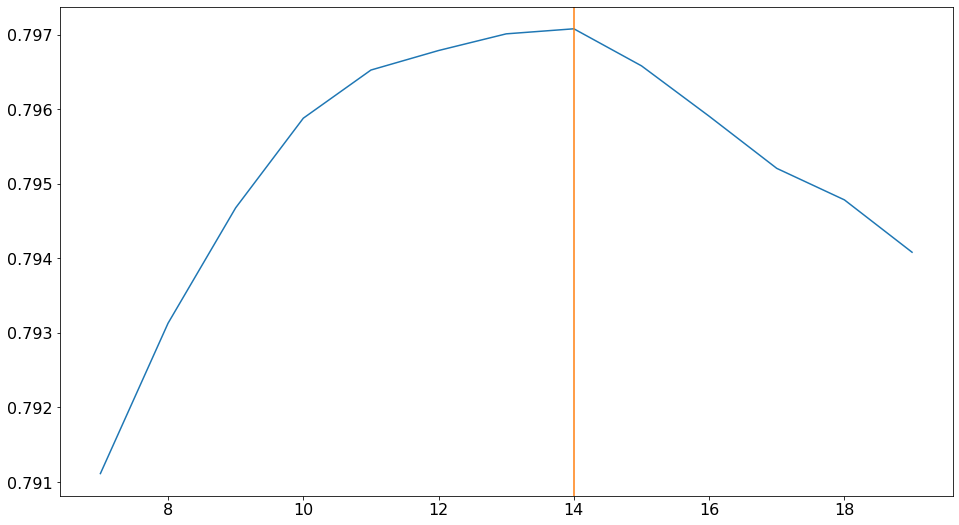

In [391]:
print(j_maxscore)
plt.figure(figsize=(16,9))
plt.plot(np.arange(7,neighbors),neighbor_score[7:])
plt.axvline(j_maxscore,c="C1")
plt.show()

10


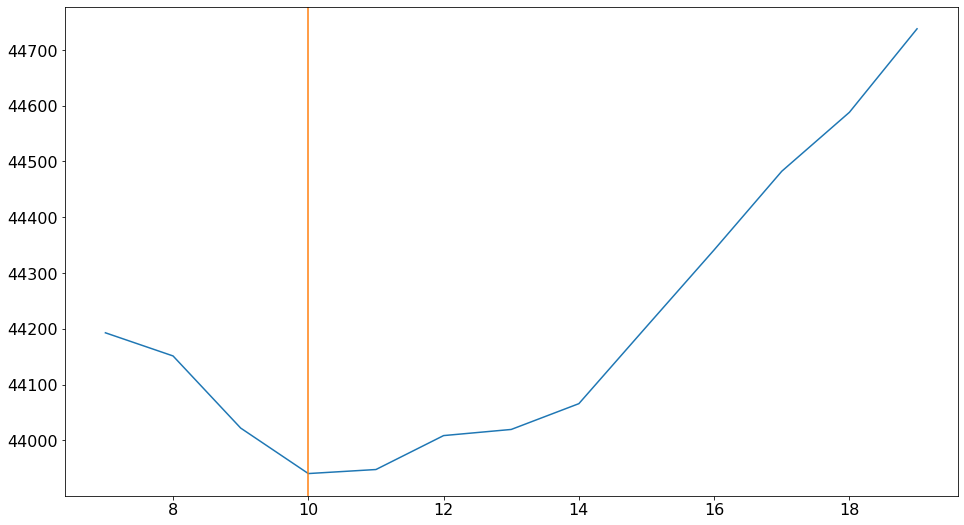

In [393]:
print(j_minerror)
plt.figure(figsize=(16,9))
plt.plot(np.arange(7,neighbors),neighbor_error[7:])
plt.axvline(j_minerror,c="C1")
plt.show()

Time Elapsed: 68.222s


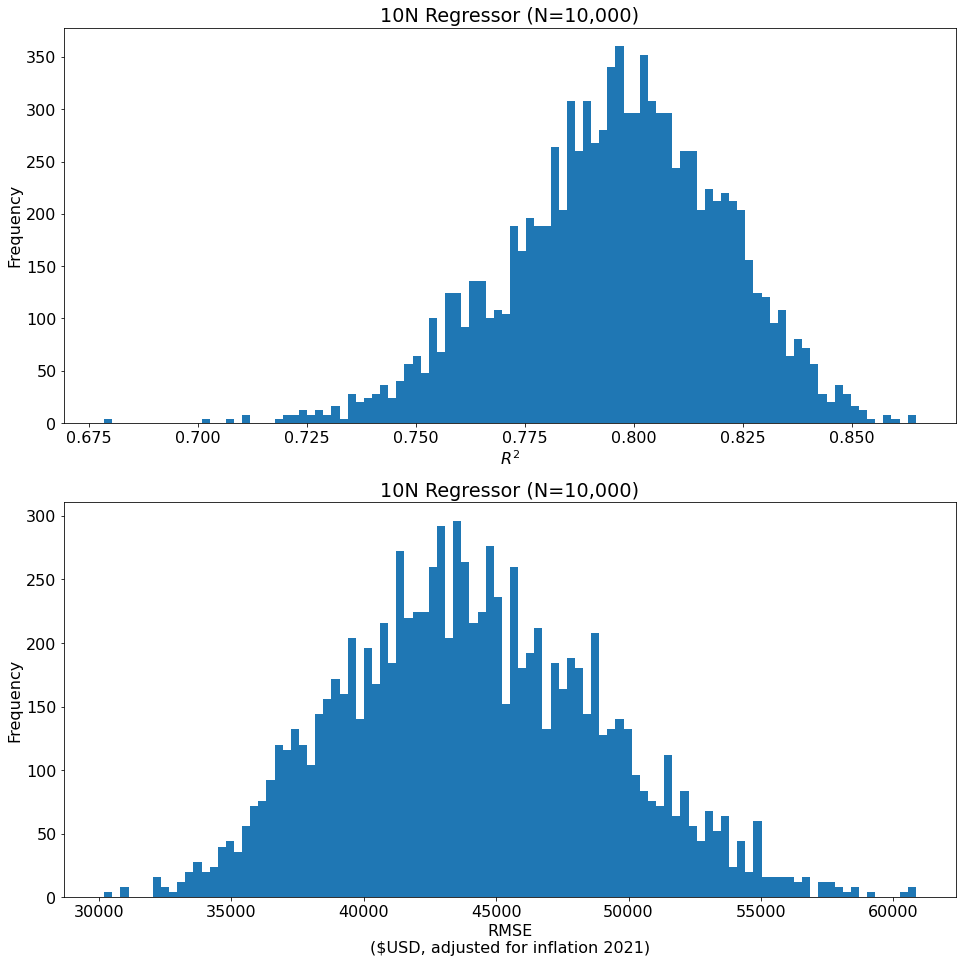

 Scores 
nobs:    	10000
minmax:  	(0.6785846414269208, 0.8647348618743101)
mean:    	0.7960248883741177
variance:	0.0005996712628181177
skewness:	-0.36893592544874404
kurtosis:	0.22319924331113628
 Error  
nobs:    	10000
minmax:  	(30197.156841336255, 60846.901972875996)
mean:    	44111.571344755735
variance:	24436147.420307625
skewness:	0.23569406868222723
kurtosis:	-0.21866934263178983


In [406]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=j_minerror)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('10N Regressor',output, int(np.sqrt(testlen)))

Time Elapsed: 78.485s


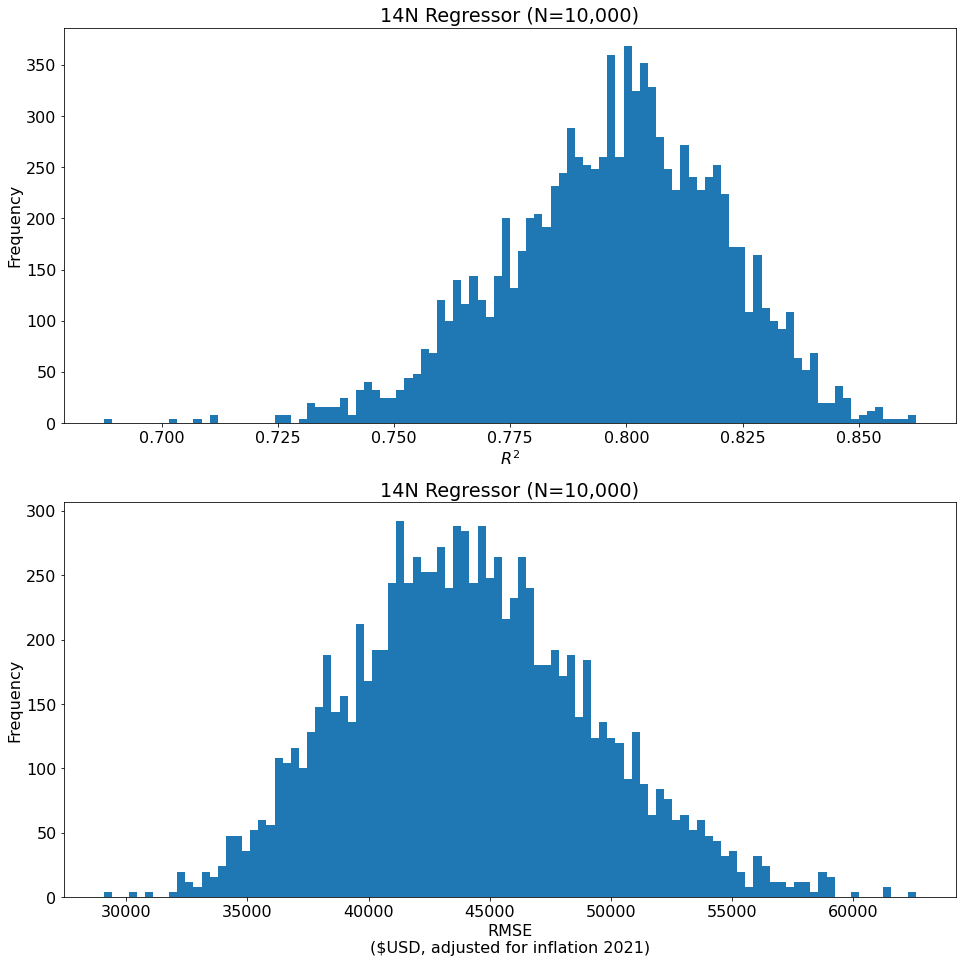

 Scores 
nobs:    	10000
minmax:  	(0.6876341677687238, 0.8622565900273679)
mean:    	0.7972790001240021
variance:	0.0005457440393918643
skewness:	-0.35884977127023976
kurtosis:	0.23524367503200772
 Error  
nobs:    	10000
minmax:  	(29086.124371548944, 62573.75314359417)
mean:    	44233.97136150056
variance:	25391028.34218397
skewness:	0.2668465633120616
kurtosis:	-0.049962385941473286


In [407]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=j_maxscore)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('14N Regressor',output, int(np.sqrt(testlen)))

Time Elapsed: 1810.619s


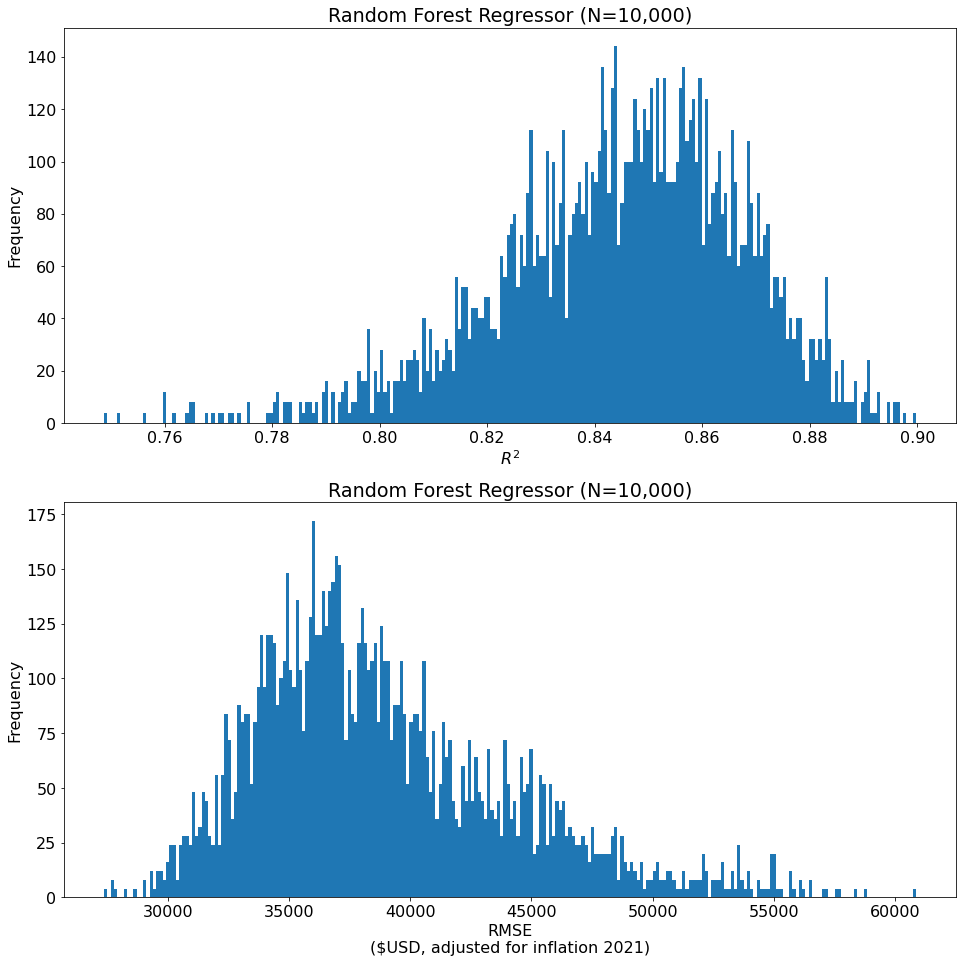

 Scores 
nobs:    	10000
minmax:  	(0.7487725555596703, 0.8997227385480598)
mean:    	0.8448949042953602
variance:	0.0005203906045594465
skewness:	-0.6206193150844479
kurtosis:	0.6269737667798942
 Error  
nobs:    	10000
minmax:  	(27372.753465149217, 60854.651258461214)
mean:    	38884.31328682293
variance:	28372209.463647053
skewness:	0.8928080595267504
kurtosis:	0.7142317734683856


In [412]:
testlen = 10000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = RandomForestRegressor()
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('Random Forest Regressor',output, 250)

In [ ]:
draw_plots('Random Forest Regressor',output, 250)

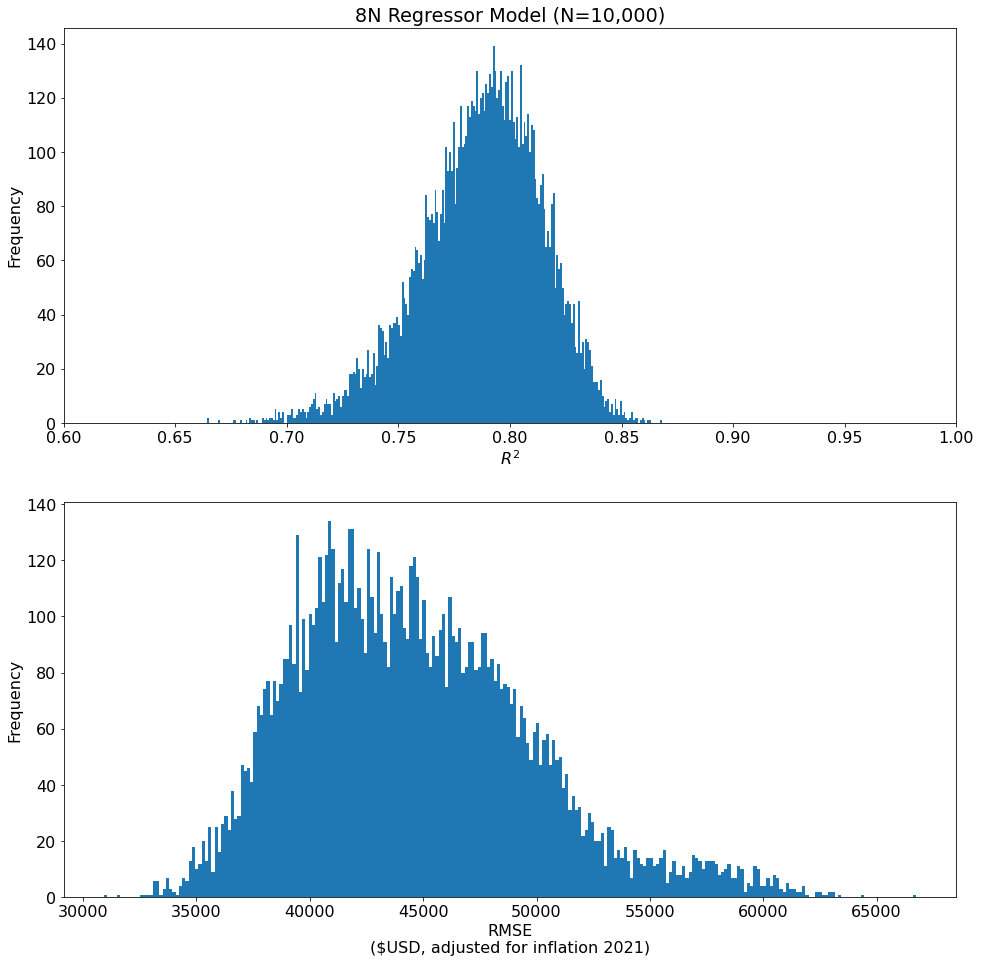

nobs:    	10000
minmax:  	(30929.365221740878, 66728.12362330407)
mean:    	44558.59968287939
variance:	26858203.256656744
skewness:	0.6351201039721451
kurtosis:	0.3445567898812283


,0
count,10000.000000
mean,0.787097
std,0.027278
min,0.664410
25%,0.770399
50%,0.789370
75%,0.806225
max,0.868033


In [141]:
testlen = 10000
bins = 250#np.sqrt(testlen).astype(int)
neighbors = 8
scores = np.zeros(testlen,dtype=np.float64)
neighbor_error = np.zeros(neighbors, dtype=np.float64)
error = np.zeros(testlen,dtype=np.float64)
for i in range(0,testlen):
    tmp = []
    sys.stdout.write(f'{i}\r')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    kreg = KNeighborsRegressor()#n_neighbors = neighbors)
    kreg.fit(X_train,y_train)
    scores[i] = kreg.score(X_test, y_test)
    error[i] = np.sqrt(np.mean((np.exp(kreg.predict(X_test)) - np.exp(y_test))**2))

plt.subplots(2,1,figsize=(16,16))

plt.subplot(211)
plt.hist(np.array(scores,dtype=np.float64),bins=bins)
plt.title(f'8N Regressor Model (N={testlen:,})')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.6,1.0)

plt.subplot(212)
plt.hist(error,bins=bins)
#plt.title(f'Simple Linear Model (N={testlen:,})')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')

plt.show()

print('========')
print(' Scores ')
tmp = sp.stats.describe(scores)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

print('========')
print(' Error  ')
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

In [ ]:
testlen = 100000

template = np.zeros(testlen,dtype=np.float64)
scores_shm = SharedMemory(create=True, size=template.nbytes)
scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)

error_shm = SharedMemory(create=True, size=template.nbytes)
error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)


model = KNeighborsRegressor(n_neighbors=99)
output = [scores,error]
job_list = divide_work(template)

start_time = time()
if __name__ == '__main__':  
    assign_work(yX, perform_work, model, job_list, output)
print(f'Time Elapsed: {time() - start_time:.3f}s')

draw_plots('8N Regressor',output)

In [60]:
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

nobs:    	10000
minmax:  	(27731.76675935293, 69348.58071205845)
mean:    	43547.60744597859
variance:	34399180.86433528
skewness:	0.28009960510440074
kurtosis:	-0.16855984167044502


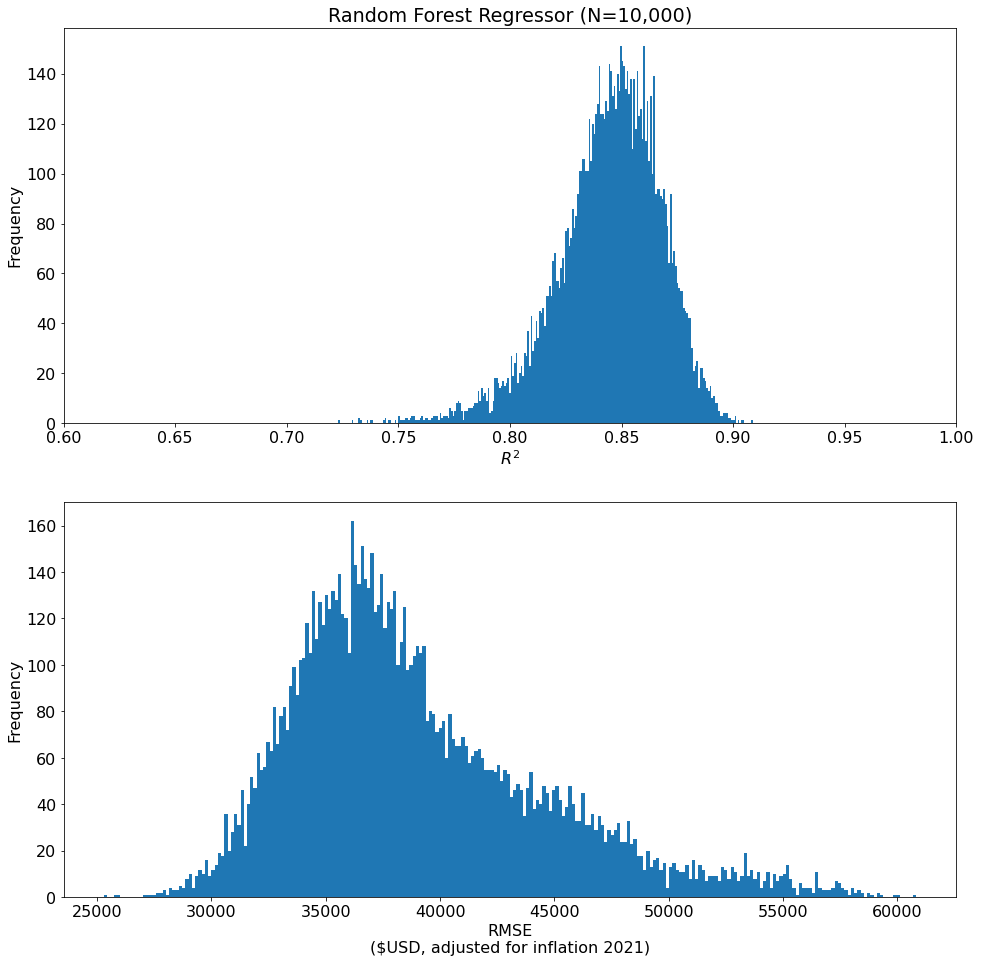

 Scores 
nobs:    	10000
minmax:  	(0.7231303974392453, 0.9087715675537853)
mean:    	0.8444923554224817
variance:	0.0005423812374974501
skewness:	-0.7372379729533589
kurtosis:	1.1164374443129725
 Error  
nobs:    	10000
minmax:  	(25307.01205921086, 60801.83386417476)
mean:    	38953.7403193029
variance:	30452851.059092287
skewness:	0.9457432132090695
kurtosis:	0.7570311722101608


In [143]:
testlen = 10000
scores = np.zeros(testlen,dtype=np.float64)
error = np.zeros(testlen,dtype=np.float64)
for i in range(0,testlen):
    sys.stdout.write(f'{i}\r')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rfreg = RandomForestRegressor(n_jobs=8)
    rfreg.fit(X_train,y_train)
    scores[i] = rfreg.score(X_test, y_test)
    error[i] = np.sqrt(np.mean((np.exp(rfreg.predict(X_test)) - np.exp(y_test))**2))

plt.subplots(2,1,figsize=(16,16))

plt.subplot(211)
plt.hist(np.array(scores,dtype=np.float64),bins=250)
plt.title(f'Random Forest Regressor (N={testlen:,})')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.6,1.0)

plt.subplot(212)
plt.hist(error,bins=250)
#plt.title(f'Simple Linear Model (N={testlen:,})')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')

plt.show()


print('========')
print(' Scores ')
tmp = sp.stats.describe(scores)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

print('========')
print(' Error  ')
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

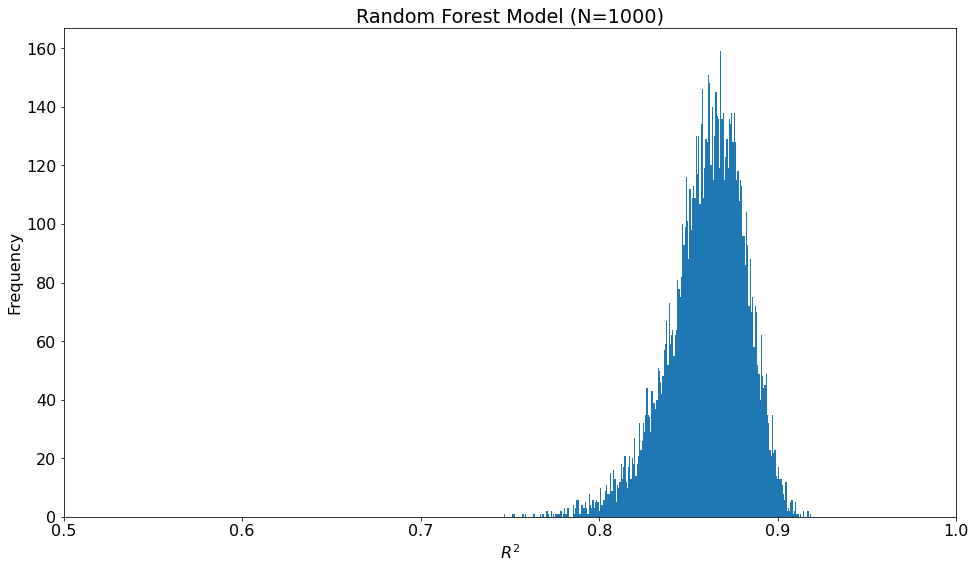

In [66]:
plt.figure(figsize=(16,9))
plt.hist(np.array(scores,dtype=np.float64),bins=250)
plt.title('Random Forest Model (N=1000)')
plt.xlabel('$R^2$')
plt.ylabel('Frequency')
plt.xlim(0.5,1.0)
plt.show()

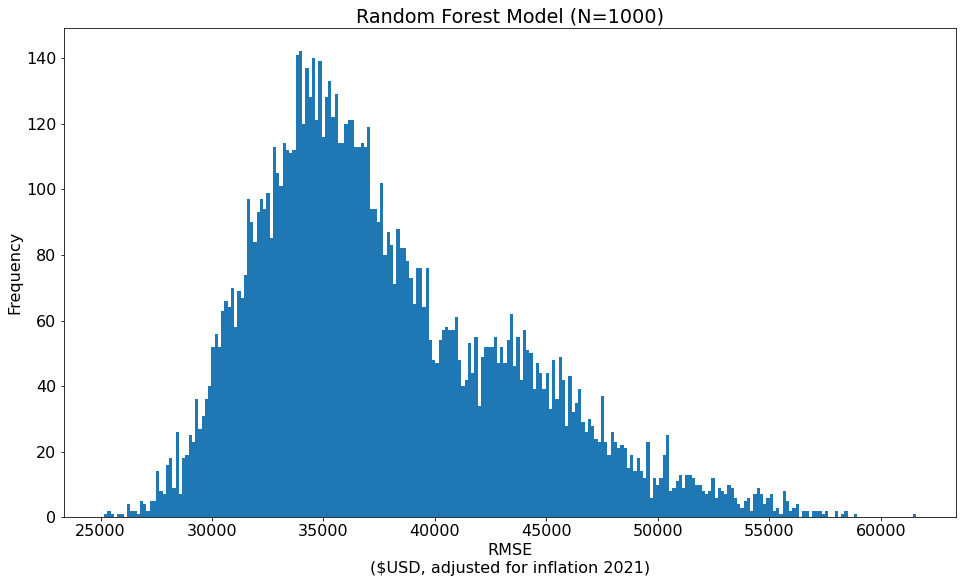

In [65]:
plt.figure(figsize=(16,9))
plt.hist(error,bins=250)
plt.title('Random Forest Model (N=1000)')
plt.xlabel('RMSE\n($USD, adjusted for inflation 2021)')
plt.ylabel('Frequency')
plt.show()

In [64]:
tmp = sp.stats.describe(error)
for i in range(len(tmp)):
    buf =  (8 - len(tmp._fields[i]))*' '
    print(f'{tmp._fields[i]}:{buf}\t{tmp[i]}')

nobs:    	10000
minmax:  	(25163.392863858324, 61570.33429452338)
mean:    	37777.005566456464
variance:	32870228.596037276
skewness:	0.7830010753307908
kurtosis:	0.22372822653642777


In [66]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [68]:
(37777)/180921

0.20880384256111784